## Load Data

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from matplotlib.gridspec import GridSpec

In [2]:
# NIAH Mamba-130M
path_to_params_for_debug_per_example = '' # insert path to .pt file
params_for_debug_per_example = torch.load(path_to_params_for_debug_per_example, map_location='cpu')

In [3]:
device = 'cuda:3'
num_layers = len(params_for_debug_per_example[0]['A'][0])
ctx_lens = [2000, 4000, 8000, 16000, 32000]

## Compute Mamba Attention

In [4]:
i_ctx_len = 0
layers = np.arange(num_layers)

average_channels = True

In [5]:
if average_channels:
    L = params_for_debug_per_example[i_ctx_len]['delta_t'][0][0].shape[2]
    attn_map = torch.zeros(len(layers), 1, L, L) # we create a dummy 'channels' dim just to be consistent with the non-averaging case
    selected_channels = range(0,1536,150) # 10 channels
else:
    attn_map = []
    selected_channels = range(0,params_for_debug_per_example[i_ctx_len]['A'][0][0].shape[0],150) # select 10 channels

for l, l_idx in enumerate(layers):
    print(f'layer {l_idx+1}')
    A = params_for_debug_per_example[i_ctx_len]['A'][0][l_idx].to(device) # [ND, d_ssm]
    delta_t = params_for_debug_per_example[i_ctx_len]['delta_t'][0][l_idx].squeeze().to(device) # [ND, L]
    Sb_x = params_for_debug_per_example[i_ctx_len]['Sb_x'][0][l_idx].squeeze().to(device)  # [d_ssm, L]
    C_t = params_for_debug_per_example[i_ctx_len]['C'][0][l_idx].squeeze().to(device)  # [d_ssm, L]
    B_t = torch.einsum('ib,jb->ijb', (delta_t, Sb_x)) # [ND, d_ssm, L] each B is discretized by the channel's delta

    L = delta_t.shape[1]
    ND = len(selected_channels)
    d_state_space = C_t.shape[0]

    if average_channels:
        for c, c_idx in enumerate(tqdm(selected_channels)):
            delta_sum_map = torch.zeros(L, L).to(device)
            for i in range(1,L):
                delta_sum_map[i,0:i] = delta_t[c_idx,i]
            delta_sum_map = torch.cumsum(delta_sum_map, dim=0)

            A_delta_t = torch.kron(delta_sum_map, A[c_idx,:].unsqueeze(dim=1).to(device))
            B_t_expanded = B_t[c_idx].repeat(L,1)
            A_t_B_t = torch.exp(A_delta_t)*(B_t_expanded)
            C_t_expanded = torch.block_diag(*C_t.T)
            attn_map[l,0] = attn_map[l] + torch.tril(C_t_expanded @ A_t_B_t).cpu() / len(selected_channels)

    else:
        delta_sum_map = torch.zeros(ND, L, L).to(device) # delta sum mat for each channel
        for i in range(1,L):
            for c, c_idx in enumerate(selected_channels):
                delta_sum_map[c,i,0:i] = delta_t[c_idx,i]
        delta_sum_map = torch.cumsum(delta_sum_map, dim=1)

        A_delta_t = torch.concat([torch.kron(delta_sum_map[c], A[c_idx,:].unsqueeze(dim=1).to(device)).unsqueeze(dim=0) for c, c_idx in enumerate(selected_channels)], dim=0)
        B_t_expanded = torch.concat([B_t[c_idx].repeat(L,1).unsqueeze(dim=0) for c, c_idx in enumerate(selected_channels)], dim=0)
        A_t_B_t = torch.exp(A_delta_t)*(B_t_expanded)
        C_t_expanded = torch.block_diag(*C_t.T)

        attn_map.append(torch.concat([(torch.tril(C_t_expanded @ A_t_B_t[c])).unsqueeze(dim=0) for c, c_idx in enumerate(selected_channels)], dim=0).cpu().unsqueeze(dim=0))

if not average_channels:
    attn_map = torch.cat(attn_map, dim=0)

layer 1


100%|██████████| 11/11 [00:04<00:00,  2.67it/s]


layer 2


100%|██████████| 11/11 [00:03<00:00,  2.83it/s]


layer 3


100%|██████████| 11/11 [00:03<00:00,  2.84it/s]


layer 4


100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


layer 5


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


layer 6


100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


layer 7


100%|██████████| 11/11 [00:03<00:00,  2.94it/s]


layer 8


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


layer 9


100%|██████████| 11/11 [00:03<00:00,  3.08it/s]


layer 10


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


layer 11


100%|██████████| 11/11 [00:03<00:00,  3.15it/s]


layer 12


100%|██████████| 11/11 [00:03<00:00,  2.87it/s]


layer 13


100%|██████████| 11/11 [00:03<00:00,  3.12it/s]


layer 14


100%|██████████| 11/11 [00:03<00:00,  3.22it/s]


layer 15


100%|██████████| 11/11 [00:03<00:00,  3.02it/s]


layer 16


100%|██████████| 11/11 [00:03<00:00,  3.07it/s]


layer 17


100%|██████████| 11/11 [00:03<00:00,  3.09it/s]


layer 18


100%|██████████| 11/11 [00:04<00:00,  2.62it/s]


layer 19


100%|██████████| 11/11 [00:03<00:00,  2.90it/s]


layer 20


100%|██████████| 11/11 [00:03<00:00,  3.06it/s]


layer 21


100%|██████████| 11/11 [00:03<00:00,  3.11it/s]


layer 22


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


layer 23


100%|██████████| 11/11 [00:03<00:00,  2.91it/s]


layer 24


100%|██████████| 11/11 [00:03<00:00,  3.13it/s]


In [6]:
attn_map.shape

torch.Size([24, 1, 2026, 2026])

In [7]:
attn_map_normalized = torch.abs(attn_map.clone())
for i_layer in range(attn_map.shape[0]):
    attn_map_normalized[i_layer,0,:,:] = attn_map_normalized[i_layer,0,:,:]/torch.max(attn_map_normalized[i_layer,0,:,:])

### All Layers Plot

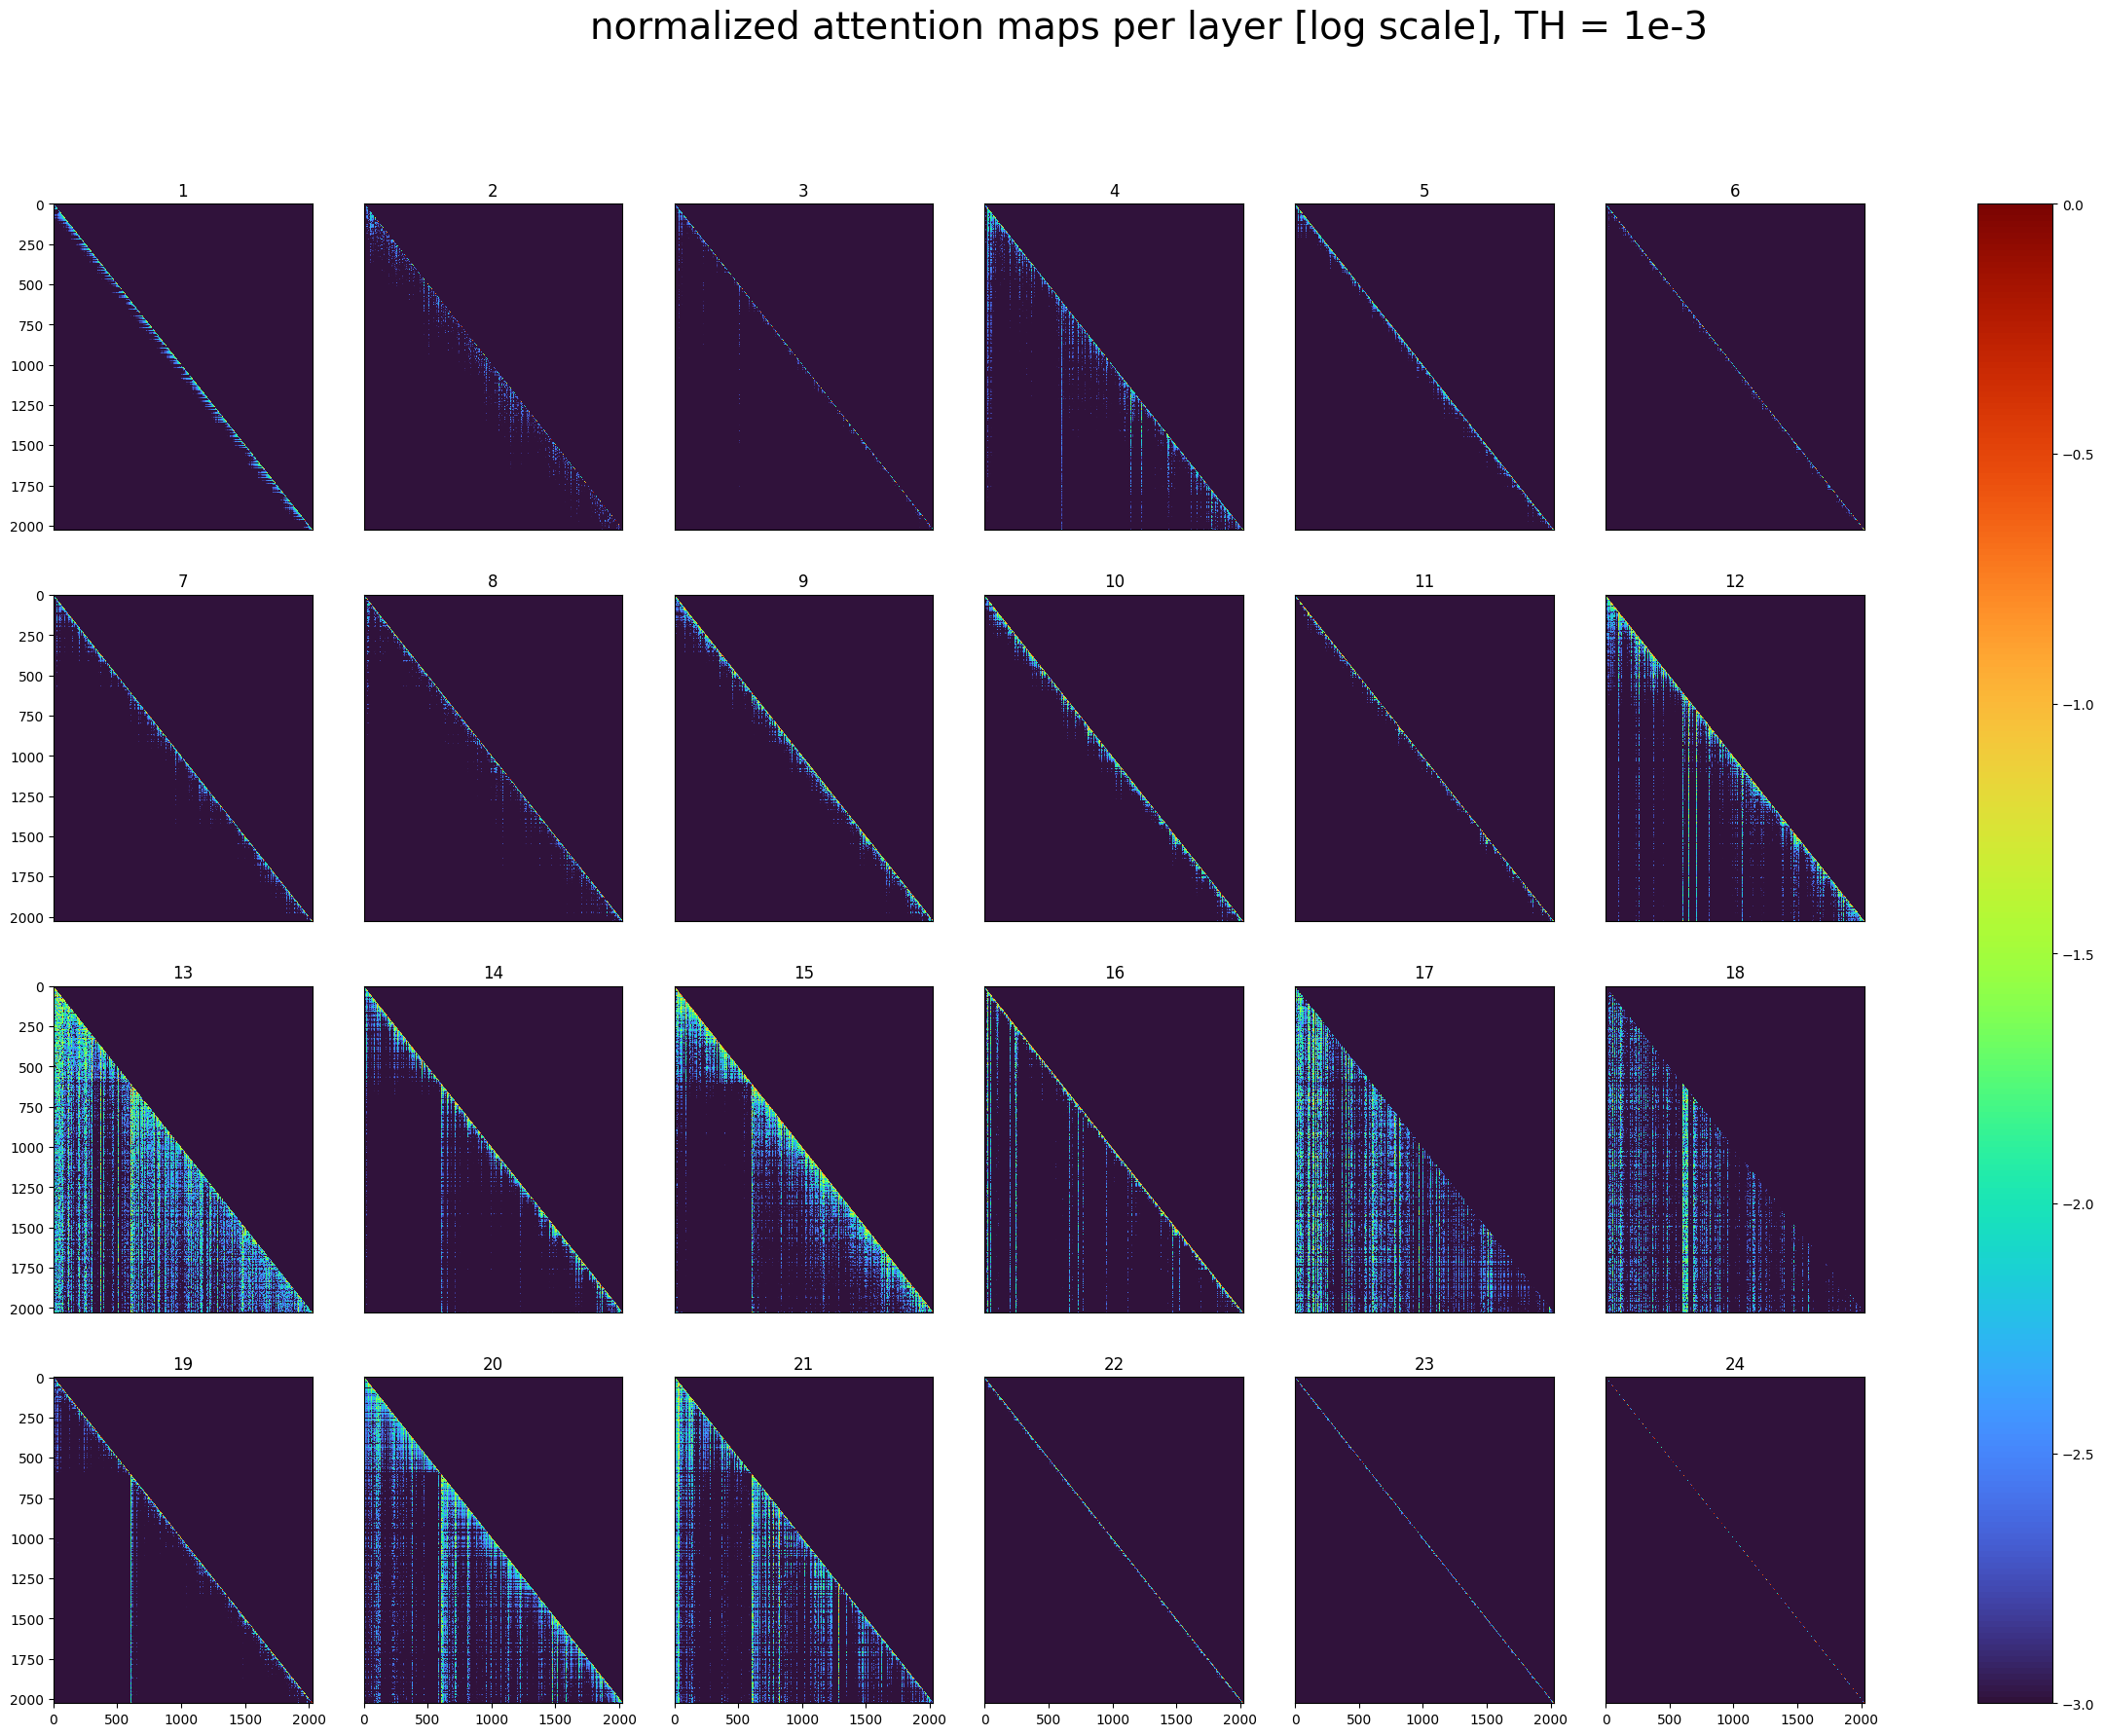

In [8]:
Nrows = 4
Ncols = 6

fig=plt.figure(figsize=(30, 20))
gs=GridSpec(Nrows,Ncols)
axes = []
for i in range(num_layers):
    axes.append(fig.add_subplot(gs[i//Ncols,i%Ncols]))

TH_power = -3
i_channel = 0
for i_ax, ax in enumerate(axes):
    i_layer = i_ax
    layer = layers[i_layer]
    if i_ax//Ncols != Nrows-1:
        ax.get_xaxis().set_visible(False)
    if i_ax%Ncols != 0:
        ax.get_yaxis().set_visible(False)
    attn_map_db = torch.max(TH_power*torch.ones(attn_map_normalized[i_layer, 0].shape),torch.log10(torch.abs(attn_map_normalized[i_layer, 0])).to(torch.float32))
    im = ax.imshow(attn_map_db, interpolation='none', aspect='auto', cmap='turbo')
    
    ax.set_title(i_layer+1)

fig.colorbar(im, ax=axes)
fig.suptitle(f'normalized attention maps per layer [log scale], TH = 1e{TH_power}', fontsize=28)
plt.show()

### Single Layer Plot

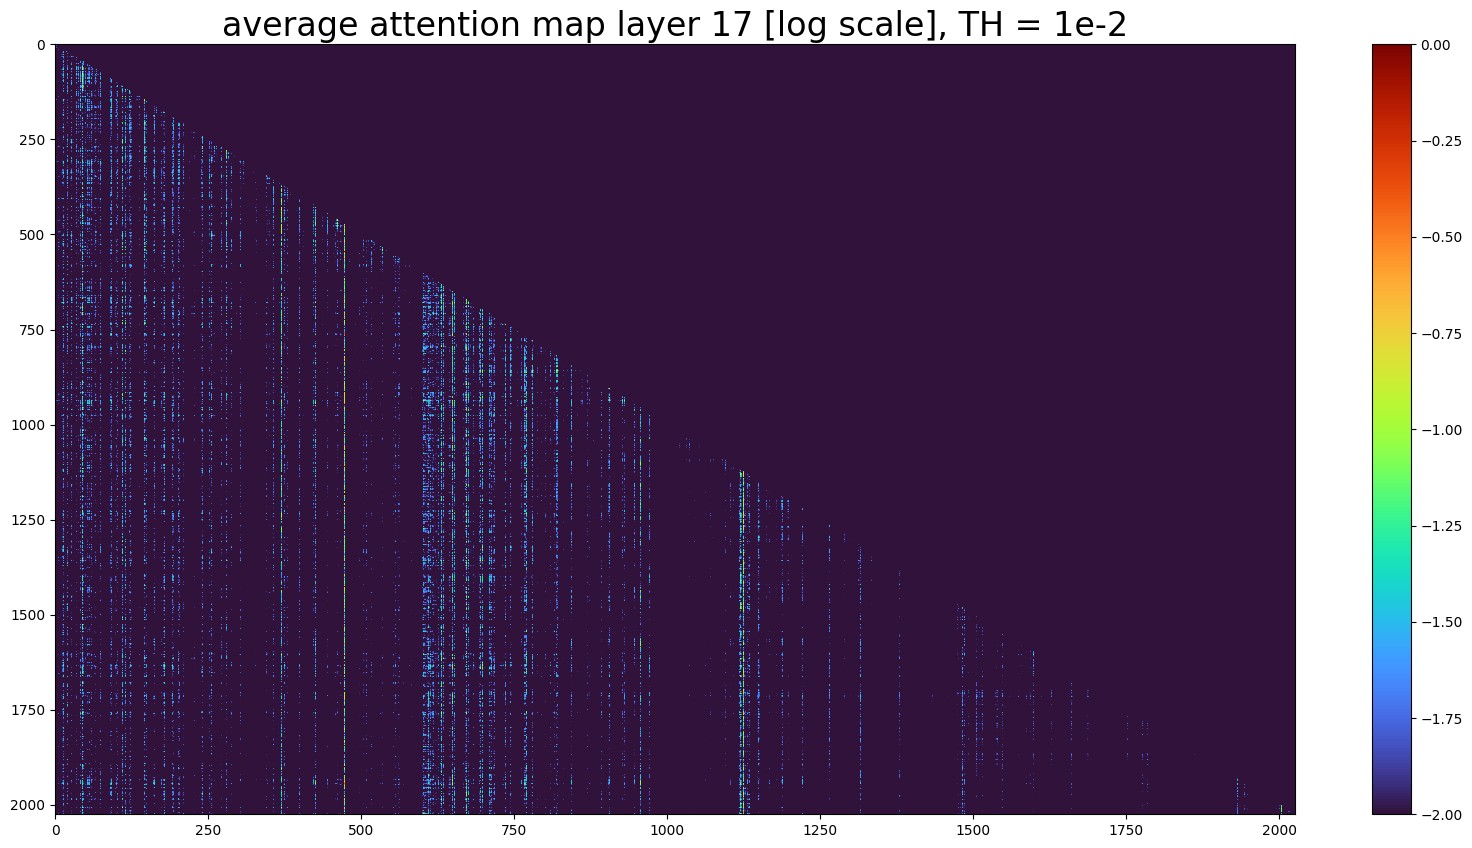

In [13]:
fig=plt.figure(figsize=(20,10))
gs=GridSpec(1,1)
axes = []
axes.append(fig.add_subplot(gs[0,0]))

TH_power = -2
i_channel = 0
i_layer = 16
for i_ax, ax in enumerate(axes):
    layer = layers[i_layer]
    attn_map_db = torch.max(TH_power*torch.ones(attn_map_normalized[i_layer,0].shape),torch.log10(torch.abs(attn_map_normalized[i_layer,0])).to(torch.float32))
    im = ax.imshow(attn_map_db, interpolation='none', aspect='auto', cmap='turbo')
    ax.set_title(f'average attention map layer {layer+1} [log scale], TH = 1e{TH_power}', fontsize=24)

fig.colorbar(im, ax=axes)
plt.show()